# 1. Objetivo

## Problemática

El Tomato Yellow Leaf Curl Virus (TYLCV) es considerado una de las virosis más devastadoras del tomate a nivel global, generando pérdidas económicas significativas en la agricultura. Se estima que, incluso en regiones con buenas prácticas de manejo como Estados Unidos y Europa, el impacto del TYLCV puede suponer hasta un 20% de la producción anual, lo que representa cientos de millones de dólares en pérdidas. En zonas tropicales y subtropicales, donde las condiciones favorecen la propagación del vector, las infecciones pueden llegar a destruir el 100% de la cosecha en situaciones extremas (Glick et al., 2009; Yan et al., 2021).

Uno de los principales retos para el control del TYLCV es la detección temprana. Los síntomas visibles, como el amarilleo y rizado de hojas, pueden tardar hasta tres semanas en aparecer tras la infección, permitiendo así que el virus se disperse inadvertidamente entre los cultivos. Además, la transmisión eficiente por la mosca blanca Bemisia tabaci, sumada a la rápida adquisición y diseminación del virus, complica el manejo en campo. El uso intensivo de insecticidas tampoco es una solución sostenible, ya que la mosca blanca desarrolla resistencias y se refugia en malezas u otros cultivos, actuando como reservorio permanente del virus (Li et al., 2022; Yan et al., 2021).



La detección temprana y automatizada mediante imágenes y algoritmos de inteligencia artificial, especialmente modelos generativos como las GANs, representa una solución disruptiva para el problema. Mientras la inspección visual tradicional suele ser subjetiva y poco eficiente en grandes extensiones de cultivo, los sistemas automáticos pueden analizar grandes volúmenes de imágenes en tiempo real, identificando incluso señales sutiles o precoces de la infección. Los modelos GAN, en particular, permiten modelar el aspecto normal de la planta y resaltar anomalías producidas por el TYLCV, facilitando una intervención rápida antes de que el brote se generalice, incluso cuando hay pocos ejemplos de enfermedad etiquetada (Kaur, 2024; Yan et al., 2021).

## Objetivo del Proyecto

Entrenar un modelo generativo adversario (GAN) con imágenes de plantas de tomate sanas y con TYLCV para detectar automáticamente anomalías visuales indicativas de esta virosis en etapas iniciales. Se justifica el uso de GAN frente a clasificadores tradicionales porque este enfoque aprende a modelar la apariencia normal de la planta y puede destacar desviaciones sutiles causadas por el virus sin requerir un gran volumen de imágenes etiquetadas de enfermedad, lo que permite una identificación más temprana y flexible de nuevos casos.

# 2. Carga de los datos 

Las imágenes empleadas en este trabajo fueron extraídas del PlantVillage Dataset.
Siendo consistente con las indicaciones del repositorio original, se cita el siguiente artículo:

Mohanty, S. P., Hughes, D. P., & Salathé, M. (2016). Using deep learning for image-based plant disease detection. Frontiers in Plant Science, 7, 1419. https://doi.org/10.3389/fpls.2016.01419

# 3. Preparación de los Datos

### Librerias necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import seaborn as sns
import torch
from collections import Counter

### Redimencion y Normalizacion de imagenes


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Redimensiona a 224x224
    transforms.ToTensor(),                   # Convierte a tensor y normaliza a [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)   # Normaliza a [-1, 1] (opcional, recomendado para GANs)
])

dataset = ImageFolder(root="../data/", transform=transform)

print(dataset.class_to_idx)
print(f"Total imágenes: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


{'anomaly': 0, 'healthy': 1}
Total imágenes: 4799


### Visualizacion inicial de los datos


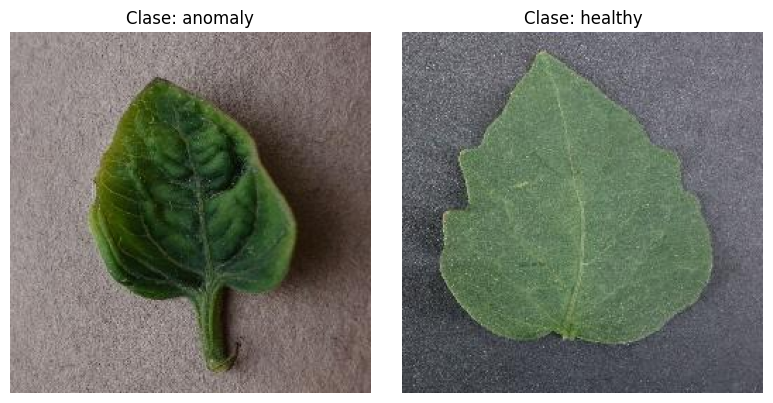

In [10]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for idx, class_name in enumerate(dataset.classes):
    for i, (path, label) in enumerate(dataset.samples):
        if label == idx:
            img_path = path
            break
    img = plt.imread(img_path)
    axs[idx].imshow(img)
    axs[idx].set_title(f"Clase: {class_name}")
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

Clase: anomaly - Cantidad de imágenes: 3208
Clase: healthy - Cantidad de imágenes: 1591


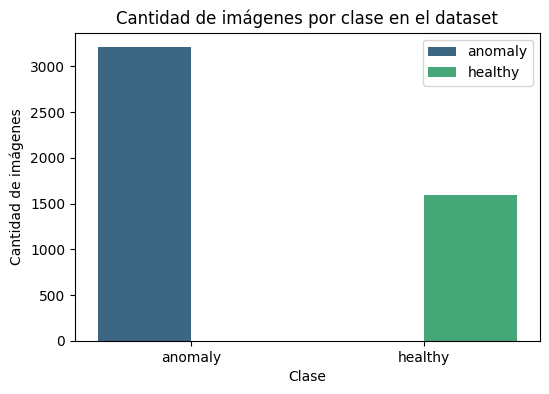

In [12]:
labels, counts = np.unique([label for _, label in dataset.samples], return_counts=True)
class_names = [dataset.classes[i] for i in labels]


for name, count in zip(class_names, counts):
    print(f"Clase: {name} - Cantidad de imágenes: {count}")

plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=counts, palette="viridis", hue=class_names)
plt.title("Cantidad de imágenes por clase en el dataset")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.show()

### Balancear data

#### Flujo correcto para balancear datos en deep learning

1. **Dividir el dataset original en train y test (por ejemplo, 80/20).**
2. **Balancear solo el DataLoader de entrenamiento** usando WeightedRandomSampler u otra técnica.
3. **El test set se deja con la distribución original** para evaluar el desempeño real del modelo.

Esto asegura que el modelo entrene de forma balanceada, pero se evalúe de forma realista.


#### Division de data

In [46]:
print(dataset.class_to_idx)
idx_healthy = dataset.class_to_idx['healthy']
idx_anomaly = dataset.class_to_idx['anomaly']

{'anomaly': 0, 'healthy': 1}


In [51]:
print(idx_healthy, idx_anomaly)

1 0


In [47]:
# Esto obtiene los índices de cada imagen que pertenece a cada clase
healthy_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == idx_healthy]
anomaly_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == idx_anomaly]


In [20]:
from torch.utils.data import random_split
train_size = int(0.8 * len(healthy_indices))
test_size = len(healthy_indices) - train_size
healthy_train_indices, healthy_test_indices = random_split(healthy_indices, [train_size, test_size], generator=torch.Generator().manual_seed(42))

In [48]:
test_indices = list(healthy_test_indices) + anomaly_indices

In [22]:
from torch.utils.data import Subset
train_dataset = Subset(dataset, healthy_train_indices)
test_dataset = Subset(dataset, test_indices)

In [49]:
print(len(test_dataset))

3527


In [50]:
print(len(train_dataset))

1272


In [52]:
labels_test = [dataset.samples[i][1] for i in test_indices]
print("healthy en test:", np.sum(np.array(labels_test) == idx_healthy))
print("anomaly en test:", np.sum(np.array(labels_test) == idx_anomaly))

healthy en test: 319
anomaly en test: 3208


In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
for images, labels in test_loader:
    print(np.unique(labels, return_counts=True))
    break

(array([1]), array([32]))


In [54]:
print("dataset.class_to_idx:", dataset.class_to_idx)

dataset.class_to_idx: {'anomaly': 0, 'healthy': 1}


#### Balancear data de entrenamiento

In [ ]:

train_targets = [dataset.samples[i][1] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(np.array(train_targets) == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_targets])
samples_weight = torch.from_numpy(samples_weight).double()
sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Ver distribucion de clases

Distribución de clases en TRAIN:
Clase: anomaly - Cantidad: 2555
Clase: healthy - Cantidad: 1284

Distribución de clases en TEST:
Clase: anomaly - Cantidad: 653
Clase: healthy - Cantidad: 307


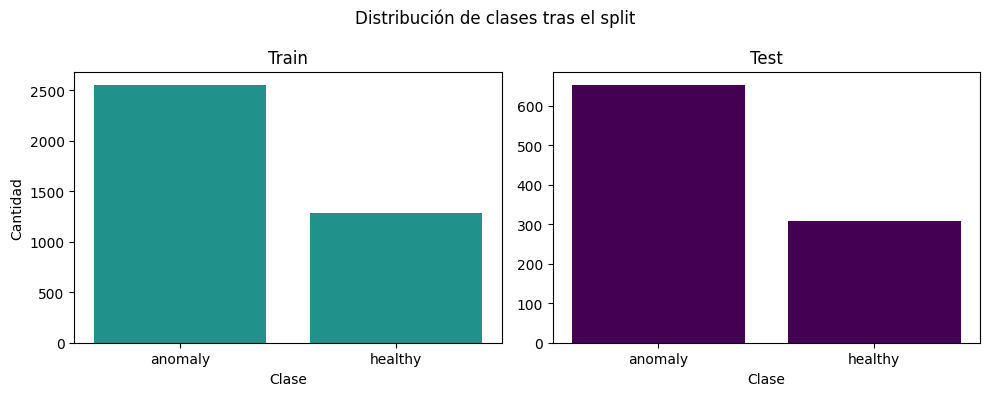

In [87]:

train_counts = np.bincount(train_targets)
test_targets = [dataset.samples[i][1] for i in test_dataset.indices]
test_counts = np.bincount(test_targets)
class_names = dataset.classes
print("Distribución de clases en TRAIN:")
for i, name in enumerate(class_names):
    print(f"Clase: {name} - Cantidad: {train_counts[i]}")
print("\nDistribución de clases en TEST:")
for i, name in enumerate(class_names):
    print(f"Clase: {name} - Cantidad: {test_counts[i]}")
    

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].bar(class_names, train_counts, color="#21918c")
axs[0].set_title("Train")
axs[0].set_ylabel("Cantidad")
axs[1].bar(class_names, test_counts, color="#440154")
axs[1].set_title("Test")
for ax in axs:
    ax.set_xlabel("Clase")
plt.suptitle("Distribución de clases tras el split")
plt.tight_layout()
plt.show()
    



Distribución de clases en un batch balanceado de entrenamiento:
Clase: anomaly - Cantidad: 16
Clase: healthy - Cantidad: 16


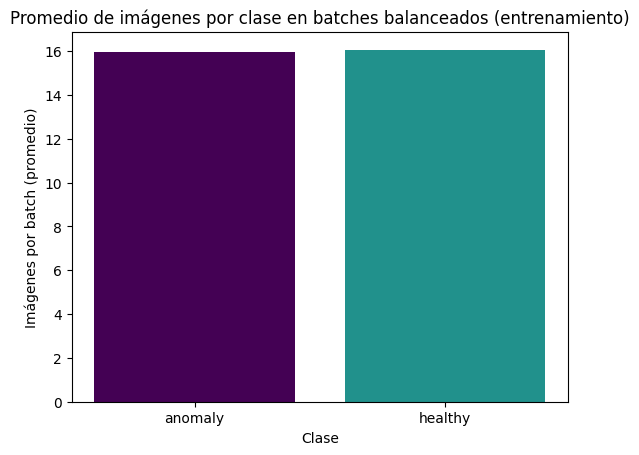

In [ ]:
num_batches = 50
distribucion = {name: [] for name in dataset.classes}
for _ in range(num_batches):
    batch = next(iter(train_loader))
    labels_batch = batch[1].numpy()
    unique, counts = np.unique(labels_batch, return_counts=True)
    for u, c in zip(unique, counts):
        distribucion[dataset.classes[u]].append(c)
        

batch = next(iter(train_loader))
labels_batch = batch[1].numpy()
unique, counts = np.unique(labels_batch, return_counts=True)
print("\nDistribución de clases en un batch balanceado de entrenamiento:")
for u, c in zip(unique, counts):
    print(f"Clase: {dataset.classes[u]} - Cantidad: {c}")


promedios = [np.mean(distribucion[name]) for name in dataset.classes]
plt.bar(dataset.classes, promedios, color=["#440154", "#21918c"])
plt.title("Promedio de imágenes por clase en batches balanceados (entrenamiento)")
plt.xlabel("Clase")
plt.ylabel("Imágenes por batch (promedio)")
plt.show()

# 4. Arquitectura del Modelo

Se usará una f-AnoGAN que es una versión mas eficiente y moderna de una AnoGAN. 

Schlegl, T., Seeböck, P., Waldstein, S. M., Schmidt-Erfurth, U., & Langs, G. (2019). f-AnoGAN: Fast unsupervised anomaly detection with generative adversarial networks. Medical Image Analysis, 54, 30-44.

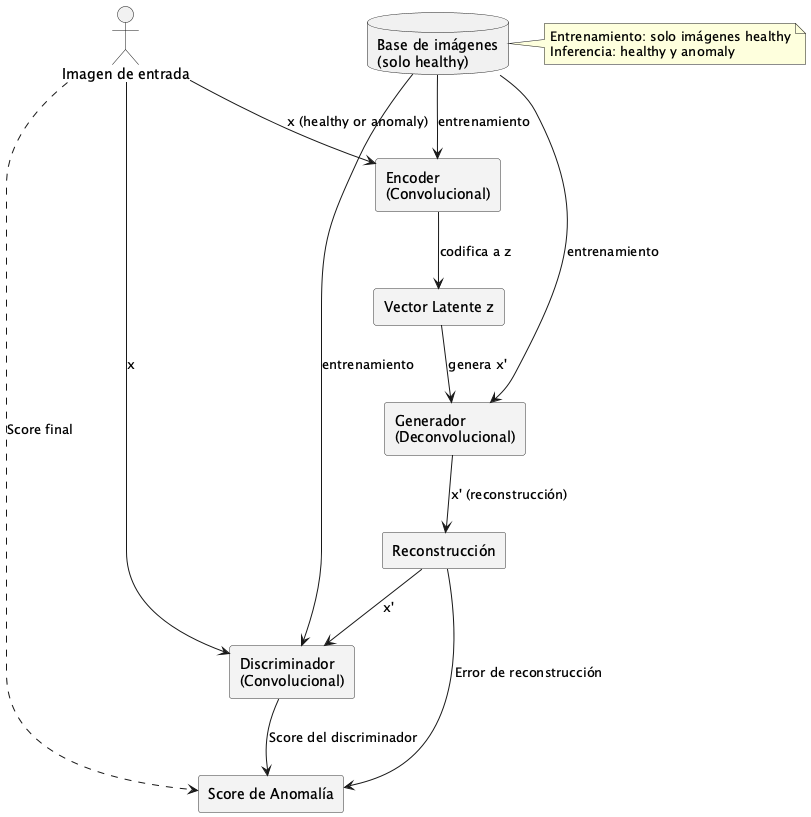

# 5. Modelo GAN

## Encoder

In [27]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 224x224 -> 112x112
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1), # 112x112 -> 56x56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1), # 56x56 -> 28x28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1), # 28x28 -> 14x14
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512*14*14, latent_dim)
        )

    def forward(self, x):
        return self.conv(x)


## Generador

In [28]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512*14*14),
            nn.BatchNorm1d(512*14*14),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (512, 14, 14)),
            nn.ConvTranspose2d(512, 256, 4, 2, 1), # 14x14 -> 28x28
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 28x28 -> 56x56
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 56x56 -> 112x112
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),    # 112x112 -> 224x224
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = self.deconv(x)
        return x


## Discriminador

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512*14*14, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


# 6. Compilar el modelo GAN

In [30]:
from torch.optim import Adam

lr = 2e-4
latent_dim = 100
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' # Use 'mps' for Apple Silicon Macs

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()


# 7. Entrenar el modelo GAN

In [32]:
epochs = 100
for epoch in range(epochs):
    for imgs, _ in train_loader:  # train_loader SOLO de imágenes healthy
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Etiquetas reales/falsas
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # -----------------
        #  Entrena Discriminador
        # -----------------
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)

        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()

        # -----------------
        #  Entrena Generador
        # -----------------
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        optim_G.zero_grad()
        g_loss.backward()
        optim_G.step()

    print(f"Epoch {epoch+1}/{epochs} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")


Epoch 1/100 | D_loss: 0.0174 | G_loss: 9.1684
Epoch 2/100 | D_loss: 0.0279 | G_loss: 8.2305
Epoch 3/100 | D_loss: 1.0372 | G_loss: 2.4656
Epoch 4/100 | D_loss: 0.1872 | G_loss: 11.3805
Epoch 5/100 | D_loss: 0.1030 | G_loss: 4.5107
Epoch 6/100 | D_loss: 0.0105 | G_loss: 8.4261
Epoch 7/100 | D_loss: 0.1945 | G_loss: 8.3068
Epoch 8/100 | D_loss: 0.1770 | G_loss: 3.9885
Epoch 9/100 | D_loss: 0.4012 | G_loss: 7.0561
Epoch 10/100 | D_loss: 0.4686 | G_loss: 2.9931
Epoch 11/100 | D_loss: 0.0682 | G_loss: 4.4289
Epoch 12/100 | D_loss: 0.0294 | G_loss: 4.2119
Epoch 13/100 | D_loss: 0.1338 | G_loss: 7.0148
Epoch 14/100 | D_loss: 0.1655 | G_loss: 5.9365
Epoch 15/100 | D_loss: 0.1186 | G_loss: 2.6997
Epoch 16/100 | D_loss: 0.2723 | G_loss: 4.3812
Epoch 17/100 | D_loss: 0.0403 | G_loss: 4.9876
Epoch 18/100 | D_loss: 0.1585 | G_loss: 7.7196
Epoch 19/100 | D_loss: 0.0788 | G_loss: 5.8687
Epoch 20/100 | D_loss: 0.0780 | G_loss: 4.8122
Epoch 21/100 | D_loss: 0.1343 | G_loss: 3.9588
Epoch 22/100 | D_loss

In [33]:
encoder = Encoder(latent_dim).to(device)
optim_E = Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
reconstruction_loss = nn.MSELoss()
epochs_encoder = 50

for epoch in range(epochs_encoder):
    for imgs, _ in train_loader:  # Solo healthy
        imgs = imgs.to(device)
        z_hat = encoder(imgs)
        recon_imgs = generator(z_hat)
        e_loss = reconstruction_loss(recon_imgs, imgs)
        
        optim_E.zero_grad()
        e_loss.backward()
        optim_E.step()
    print(f"Encoder Epoch {epoch+1}/{epochs_encoder} | Recon Loss: {e_loss.item():.4f}")


Encoder Epoch 1/50 | Recon Loss: 0.0950
Encoder Epoch 2/50 | Recon Loss: 0.0818
Encoder Epoch 3/50 | Recon Loss: 0.0837
Encoder Epoch 4/50 | Recon Loss: 0.0766
Encoder Epoch 5/50 | Recon Loss: 0.0734
Encoder Epoch 6/50 | Recon Loss: 0.0763
Encoder Epoch 7/50 | Recon Loss: 0.0711
Encoder Epoch 8/50 | Recon Loss: 0.0671
Encoder Epoch 9/50 | Recon Loss: 0.0639
Encoder Epoch 10/50 | Recon Loss: 0.0784
Encoder Epoch 11/50 | Recon Loss: 0.0751
Encoder Epoch 12/50 | Recon Loss: 0.0692
Encoder Epoch 13/50 | Recon Loss: 0.0692
Encoder Epoch 14/50 | Recon Loss: 0.0679
Encoder Epoch 15/50 | Recon Loss: 0.0607
Encoder Epoch 16/50 | Recon Loss: 0.0782
Encoder Epoch 17/50 | Recon Loss: 0.0705
Encoder Epoch 18/50 | Recon Loss: 0.0695
Encoder Epoch 19/50 | Recon Loss: 0.0642
Encoder Epoch 20/50 | Recon Loss: 0.0645
Encoder Epoch 21/50 | Recon Loss: 0.0593
Encoder Epoch 22/50 | Recon Loss: 0.0771
Encoder Epoch 23/50 | Recon Loss: 0.0619
Encoder Epoch 24/50 | Recon Loss: 0.0596
Encoder Epoch 25/50 | Rec

# 8. Predicción

In [34]:
generator.eval()
encoder.eval()

Encoder(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=100352, out_features

In [67]:
all_scores = []
all_labels = []
recon_images = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        z_hat = encoder(imgs)
        recon_imgs = generator(z_hat)
        
        # Calcular la distancia L2 entre la imagen original y la reconstruida
        scores = torch.mean((imgs - recon_imgs)**2, dim=(1, 2, 3)).cpu().numpy()
        
        all_scores.extend(scores)
        all_labels.extend(labels.numpy())
        recon_images.append(recon_imgs.cpu())

In [68]:
import numpy as np
healthy_scores = np.array([s for s, l in zip(all_scores, all_labels) if l == idx_healthy])
umbral = np.percentile(healthy_scores, 95)  # Umbral en el percentil 95 de las imágenes saludables
print(f"Umbral para detección de anomalías: {umbral:.4f}")

Umbral para detección de anomalías: 0.1268


In [70]:
from sklearn.metrics import confusion_matrix, classification_report

preds = [1 if s > umbral else 0 for s in all_scores]  
print(confusion_matrix(all_labels, preds))
print(classification_report(all_labels, preds, target_names=["anomaly", "healthy"]))


[[3094  114]
 [ 303   16]]
              precision    recall  f1-score   support

     anomaly       0.91      0.96      0.94      3208
     healthy       0.12      0.05      0.07       319

    accuracy                           0.88      3527
   macro avg       0.52      0.51      0.50      3527
weighted avg       0.84      0.88      0.86      3527



In [71]:
idx_anomaly = dataset.class_to_idx["anomaly"]
idx_healthy = dataset.class_to_idx["healthy"]

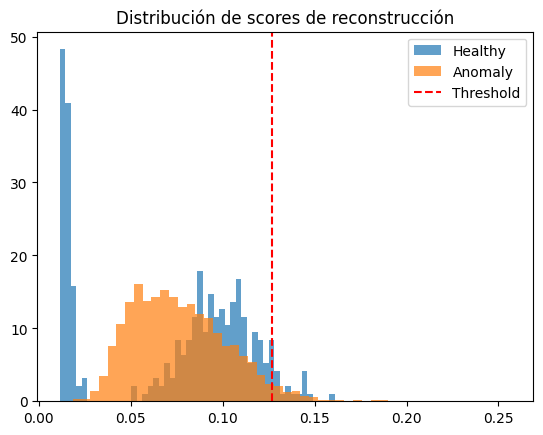

In [72]:
import matplotlib.pyplot as plt

healthy = [score for score, label in zip(all_scores, all_labels) if label == idx_healthy]
anomaly = [score for score, label in zip(all_scores, all_labels) if label == idx_anomaly]

plt.hist(healthy, bins=50, alpha=0.7, label="Healthy", density=True)
plt.hist(anomaly, bins=50, alpha=0.7, label="Anomaly", density=True)
plt.axvline(umbral, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("Distribución de scores de reconstrucción")
plt.show()


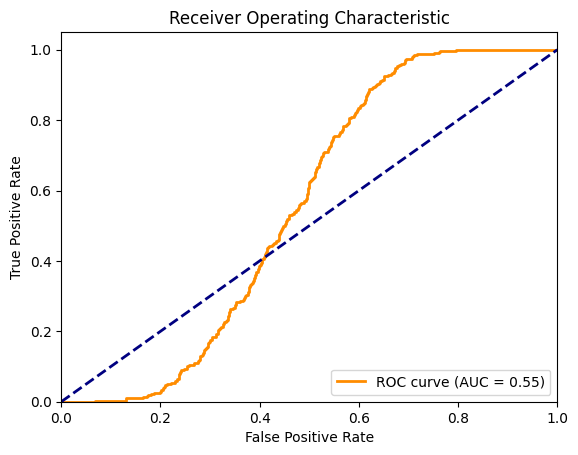

In [66]:
from sklearn.metrics import roc_curve, auc

labels_bin = [0 if label == idx_anomaly else 1 for label in all_labels]

fpr, tpr, thresholds = roc_curve(labels_bin, all_scores)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 9. Acciones